In [64]:
import IPython.display as ipd
import librosa
import librosa.display
import scipy.signal as signal
import numpy as np
import matplotlib.pyplot as plt

In [65]:
wav, sr = librosa.load(librosa.ex("trumpet"))
wav = wav[:10000]

In [66]:
# # sin
# sr = 44100
# f = 1000
# wav = np.sin(2*np.pi*f*np.arange(10000)/sr)

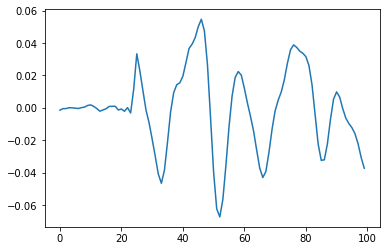

In [67]:
plt.plot(wav[:100])

In [68]:
nfft = 512
win_length = nfft
hop_length = nfft//2
name_window = 'han' #'square'  'triang', 'han', 'hamming'

if name_window == 'square':
    window = np.ones(shape=(win_length,))
else:
    window = signal.get_window(window=name_window, Nx=nfft)

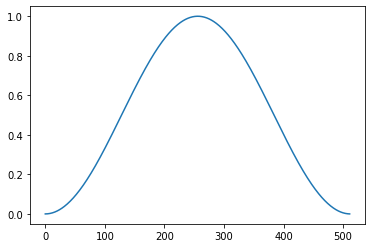

In [69]:
plt.plot(window)

In [70]:
# windowing
# print(wav.shape)
# if wav.shape[-1] % hop_length != 0:
#     num_pad = (wav.shape[-1]//hop_length+1)*hop_length-wav.shape[-1]
#     paddings = np.zeros(shape=(len(wav.shape), 2), dtype=int)
#     paddings[-1, -1] = num_pad
#     wav_padded = np.pad(wav, pad_width=paddings)
# else:
wav_padded = wav.astype(np.float32)

# print(wav_padded.shape)

padding = [(0, 0) for _ in range(wav_padded.ndim)]
padding[-1] = (int(nfft // 2), int(nfft // 2))
wav_padded = np.pad(wav_padded, padding, mode="constant")

# print(wav_padded.shape)

num_frame = int((wav_padded.shape[-1] - nfft ) //hop_length)+1
frames = np.zeros(shape=(num_frame, nfft), dtype=np.float32)

curr_index = 0
for n_frame in range(num_frame):
    frames[n_frame, ...] = window*wav_padded[...,curr_index:curr_index+nfft]
    curr_index += hop_length


In [71]:
wav_padded.dtype, wav_padded.shape

(dtype('float32'), (10512,))

In [72]:
# fft
fft_frames = np.fft.fft(frames, n=nfft, axis=-1)
print(fft_frames.shape, fft_frames.dtype)

fft_frames_stft = librosa.stft(y=wav, n_fft=nfft, hop_length=hop_length, 
                            win_length=nfft, window=name_window, center=True,
                            dtype=np.complex128, pad_mode="constant")
print(fft_frames_stft.shape)  

(40, 512) complex128
(257, 40)


(40, 257) float64
(40, 257) float64
1.8865382034327638e-07
(array([21]), array([92]))
1.8865382034327638e-07
(257,)
(257,)


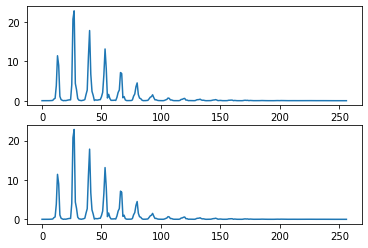

In [73]:

# Comparte stft_scratch and librosa.stft
frame_fft = np.abs(fft_frames[..., :nfft//2+1])
frame_fft_stft = np.abs(fft_frames_stft.T)

print(frame_fft.shape, frame_fft.dtype)
print(frame_fft_stft.shape, frame_fft_stft.dtype)  
print(np.max(frame_fft - frame_fft_stft))
print(np.where((frame_fft - frame_fft_stft)==np.max(frame_fft - frame_fft_stft)))

index = 21
frame_fft = frame_fft[index].flatten()
frame_fft_stft = frame_fft_stft[index].flatten()

print(np.max(frame_fft - frame_fft_stft))
print(frame_fft.shape)
print(frame_fft_stft.shape)

fig, (ax0, ax1) = plt.subplots(nrows=2)
ax0.plot(frame_fft)
ax1.plot(frame_fft_stft)

In [74]:
# ifft
ifft_frames = np.fft.ifft(frames, n=nfft, axis=-1).real
print(ifft_frames.shape, ifft_frames.dtype)

(40, 512) float64


In [75]:
# overlap and add
num_frame = ifft_frames.shape[0]
shape_fft = list(ifft_frames.shape)
n_frame = shape_fft[0]
wav_result = np.zeros(shape=nfft+(n_frame-1)*hop_length, dtype=ifft_frames.dtype) # TODO, size
curr_index = 0
# print(wav_padded.shape, wav_result.shape, wav_result.dtype)

for n_frame in range(num_frame):
    # print(curr_index, curr_index+nfft, wav_result.shape)
    wav_result[...,curr_index:curr_index+nfft] += window*frames[n_frame, ...]
    curr_index += hop_length

def window_sumsquare_scratch(window, n_frames, win_length, n_fft, hop_length, dtype, norm=None):
    """ window_sumsquare
        1. getting window
        2. normalizae **2
        3. pad_center depending on fft size
        4. overlap and add(hopping the window and add)
        
    Hypothesis: window length is same as n_fft. If different, it should be centering
    """
    if win_length is None:
        win_length = n_fft

    n = n_fft + hop_length * (n_frames - 1)
    x = np.zeros(n, dtype=dtype)
    # Compute the squared window at the desired length
    win_sq = signal.get_window(window=window, Nx=win_length)
    win_sq = librosa.util.normalize(win_sq, norm=norm) ** 2
    # win_sq = util.pad_center(win_sq, size=n_fft)
    
    # Fill the envelope, __window_ss_fill
    n_fft = len(win_sq)
    for i in range(n_frames):
        sample = i * hop_length
        x[sample : min(n, sample + n_fft)] += win_sq[: max(0, min(n_fft, n - sample))]

    return x

# Normalize by sum of squared window, librosa.filters.window_sumsquare
ifft_window_sum = window_sumsquare_scratch(
    window=name_window,
    n_frames=num_frame,
    win_length=win_length,
    n_fft=nfft,
    hop_length=hop_length,
    dtype=wav_result.dtype,
)

approx_nonzero_indices = ifft_window_sum > librosa.util.tiny(ifft_window_sum)
wav_result[..., approx_nonzero_indices] /= ifft_window_sum[approx_nonzero_indices]

wav_result = wav_result[..., nfft//2:-nfft//2]
wav_result = wav_result[..., :wav.shape[-1]]


In [76]:
wav_result_istft = librosa.istft(stft_matrix=fft_frames_stft, hop_length=hop_length,
                                win_length=nfft, n_fft=nfft, window=name_window, 
                                center=True, length=wav.shape[-1])
print(wav_result_istft.shape)

(10000,)


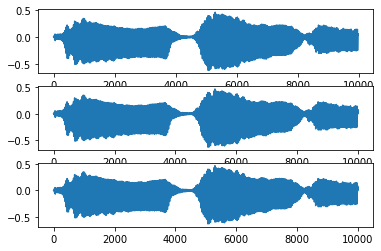

In [77]:
fig, (ax0, ax1, ax2) = plt.subplots(nrows=3)
ax0.plot(wav_result)
ax1.plot(wav)
ax2.plot(wav_result_istft)

In [78]:
ipd.Audio(data=wav, rate=sr)

In [79]:
ipd.Audio(data=wav_result, rate=sr)

In [80]:
ipd.Audio(data=wav_result_istft, rate=sr)

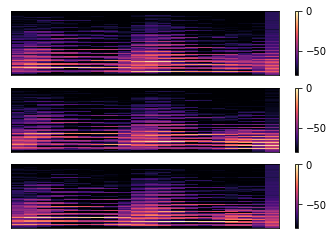

In [81]:
fig, (ax0, ax1, ax2) = plt.subplots(3, 1, sharey=True)

def show_stft(y, _fig, _ax):
    D = librosa.stft(y)  # STFT of y
    S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
    img = librosa.display.specshow(S_db, ax=_ax)
    _fig.colorbar(img, ax=_ax)

show_stft(wav, fig, ax0)
show_stft(wav_result, fig, ax1)
show_stft(wav_result_istft, fig, ax2)